In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display
from queue import PriorityQueue
import os
import wget

# Klasa reprezentująca graf

In [2]:
class Graph:
    def __init__(self, graph_dict={}, is_directed=False):
        self.dict = graph_dict
        self.is_directed = is_directed

    # dict initializer
    @classmethod
    def from_dict(cls, graph, is_directed):
        return cls(graph, is_directed)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if vertices is None:
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dictionary of neighbours form.
        """
        result = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            result[v] = neighbours
        return result

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in in dictionary of neighbours form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def __str__(self):
        result = ""
        for v in self.dict:
            result += f"{v}:"
            for u in self.dict[v]:
                result += f" {u}"
            result += "\n"
        return result

    def plot(self, random_seed=1):
        G = None
        arrows_style = None
        if self.is_directed:
            G = nx.DiGraph()
            arrows_style = "-|>"
        else:
            G = nx.Graph()
            arrows_style = "-"
        G.add_nodes_from(self.dict.keys())
        pos = nx.spring_layout(G, seed=random_seed)

        for vertex, neighbours in self.dict.items():
            for neighbour in neighbours:
                G.add_edge(vertex, neighbour)

        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
                node_size=1000, arrows=True, arrowstyle=arrows_style)
        plt.title("Graph Visualization")
        plt.show()

    def add_vertex(self, vertex):
        """
        Dodaje nowy wierzchołek do grafu.
        """
        if vertex not in self.dict.keys():
            self.dict[vertex] = []

    def add_arc(self, arc):
        """
        Dodaje nowy łuk do grafu skierowanego.
        """
        if self.is_directed:
            u, v = arc
            self.add_vertex(u)
            self.add_vertex(v)
            if v not in self.dict[u]:
                self.dict[u].append(v)
        else:
            raise ValueError("Operacja dodania łuku nie jest dozwolona dla grafów nieskierowanych.")

    def add_edge(self, edge):
        """
        Dodaje nową krawędź do grafu nieskierowanego.
        """
        if not self.is_directed:
            u, v = edge
            self.add_vertex(u)
            self.add_vertex(v)
            if u == v:
                raise ValueError("Pętla niedozwolona.")
            if v not in self.dict[u]:
                self.dict[u].append(v)
            if u not in self.dict[v]:
                self.dict[v].append(u)
        else:
            raise ValueError("Operacja dodania krawędzi nie jest dozwolona dla grafów skierowanych.")

    #Funkcje generujące grafy losowe
    @staticmethod
    def generate_random_graph(vertices_count: int, prob=1/2, random_seed=None):
        """
        Generates a random undirected graph with the given number of vertices and given probability of an edge appearing.
        """
        random_state = np.random.default_rng(random_seed)
        random_graph = Graph({}, is_directed=False)
        for i in range(1, vertices_count+1):
            random_graph.add_vertex(i)
            for j in range(1, i):
                if random_state.random() < prob:
                    random_graph.add_edge((i, j))

        return random_graph

    @staticmethod
    def generate_random_cycle(vertices_count: int, random_seed=None):
        """
        Generates a random undirected cycle with the given number of vertices.
        """
        random_state = np.random.default_rng(random_seed)
        random_cycle = Graph({}, is_directed=False)

        vertices = list(range(1, vertices_count + 1))
        for v in vertices:
            random_cycle.add_vertex(v)

        random_state.shuffle(vertices)

        for i in range(len(vertices) - 1):
            random_cycle.add_edge((vertices[i], vertices[i+1]))
        random_cycle.add_edge((vertices[-1], vertices[0]))
        return random_cycle

    @staticmethod
    def generate_random_bipartite_graph(vertices_count1: int, vertices_count2: int, prob=1/2, random_seed=None):
        """
        Generates a random bipartite graph with the given number of vertices in each group and given probability of an edge.
        """
        random_state = np.random.default_rng(random_seed)

        total_vertices = vertices_count1 + vertices_count2
        left_vertices = list(range(vertices_count1))
        right_vertices = list(range(vertices_count1, total_vertices))
        graph_dict = {v: [] for v in range(total_vertices)}

        for u in left_vertices:
            for v in right_vertices:
                if random_state.random() < prob:
                    graph_dict[u].append(v)
                    graph_dict[v].append(u)

        random_bipartite_graph = Graph(graph_dict, is_directed=False)
        return random_bipartite_graph

    #Funkcje do odczytu i zapisu grafów
    def to_edges_list_file(self, filename):
        """
        Zapisuje graf do pliku w formie listy sąsiedztwa.
        """
        with open(filename, "w") as file:
            for u in self.dict:
                for v in self.dict[u]:
                    line = f"{u} {v}\n"
                    file.write(line)

    def to_neighbours_list_file(self, filename):
        """
        Zapisuje graf do pliku w formie listy sąsiedztwa.
        """
        with open(filename, "w") as file:
            file.write(str(self))

    @staticmethod
    def from_edges_list_file(filename, is_directed=False):
        """
        Wczytuje graf z pliku w postaci listy krawędzi.
        """
        new_graph = Graph({}, is_directed=is_directed)
        file = open(filename, "r")
        with open(filename, "r") as file:
            for line in file:
                words = line.strip().split()
                if len(words) == 1:
                    new_graph.add_vertex(words[0])
                elif len(words) >= 2:
                    if is_directed:
                        new_graph.add_arc(words)
                    else:
                        new_graph.add_edge(words)
        return new_graph

    @staticmethod
    def from_neighbours_list_file(filename, is_directed=False):
        """
        Wczytuje graf z pliku w postaci listy sąsiedztwa.
        """
        new_graph = Graph({}, is_directed=is_directed)
        file = open(filename, "r")
        with open(filename, "r") as file:
            for line in file:
                words = line.replace(":", "").strip().split()
                starting_vertex = words[0]
                if len(words) == 1:
                    new_graph.add_vertex(starting_vertex)
                elif len(words) >= 2:
                    for ending_vertex in words[1:]:
                        if is_directed:
                            new_graph.add_arc((starting_vertex, ending_vertex))
                        else:
                            new_graph.add_edge((starting_vertex, ending_vertex))
        return new_graph

    #Funkcje do kodów Prufera i drzew
    def Prufer_code(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.dict)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.dict) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph({}, is_directed=False)
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
             if not x in clist:    # x - least leaf
                break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree

    def preorder(self, start):
        """
        Finds a preorder using Depth first search starting from the given vertex.
        """
        visited = set()
        preorder = []

        def dfs(vertex):
            visited.add(vertex)
            preorder.append(vertex)
            for neighbour in self.dict[vertex]:
                if neighbour not in visited:
                    dfs(neighbour)

        dfs(start)
        return preorder

    def postorder(self, start):
        """
        Finds a postorder using Depth first search starting from the given vertex.
        """
        visited = set()
        postorder = []

        def dfs(vertex):
            visited.add(vertex)
            for neighbour in self.dict[vertex]:
                if neighbour not in visited:
                    dfs(neighbour)
            postorder.append(vertex)

        dfs(start)
        return postorder

    def distances(self, v):
        """
        Oblicza odległości z wierchołka v do każdego wierchołka z grafu.
        """
        dist = {v: 0}
        queue = [v]
        while len(queue) > 0:
            u = queue.pop(0)
            for w in self.dict[u]:
                if not w in dist:
                    dist[w] = dist [u] + 1
                    queue.append(w)
        return dist

    #Spójne składowe i sortowanie topologiczne
    def connected_componentsDFS(self):
        """
        Finds all vertices of connected components of the graph using DFS.
        """
        def dfs(u):
            for w in self.dict[u]:
                if w not in VT[0]:
                    VT[0].add(w)
                    VT[-1].add(w)
                    dfs(w)


        VT = [set()]
        for v in self.dict:
            if not v in VT[0]:
                VT[0].add(v)
                VT.append(set([v]))
                dfs(v)
        return VT[1:]

    def connected_componentsBFS(self):
        """
        Finds all vertices of connected components of the graph using iterative BFS.
        """
        visited = set()
        components = []

        for start in self.dict:
            if start in visited:
                continue

            queue = PriorityQueue()
            queue.put(start)
            visited.add(start)
            component = []

            while not queue.empty():
                vertex = queue.get()
                component.append(vertex)

                for neighbour in self.dict[vertex]:
                    if neighbour not in visited:
                        visited.add(neighbour)
                        queue.put(neighbour)

            components.append(component)

        return components

    def connected_components(self, version="DFS"):
        """
        Finds all connected components of a graph.
        """
        components = []
        if version == "DFS":
            components = self.connected_componentsDFS()
        if version == "BFS":
            components = self.connected_componentsBFS()
        component_graphs = []
           
        for component in components:
            subgraph = Graph({}, is_directed=self.is_directed)
            for vertex in component:
                subgraph.dict[vertex] = self.dict[vertex].copy()
            component_graphs.append(subgraph)
        return component_graphs

    def transpose(self):
        """
        Returns a transposition of a graph.
        """
        graph_T = {}
        if self.is_directed:
            for u in self.dict:
                graph_T.setdefault(u, [])
            for u, neighbors in self.dict.items():
                for v in neighbors:
                    graph_T.setdefault(v, []).append(u)
        else:
            graph_T = self.dict
        self.T = Graph(graph_T, self.is_directed)
        return graph_T
        
    def strongly_connected_components_vertices(self):
        """
        Finds all vertices of strongly connected components of the directed graph using DFS and graph trasposition.
        """
        if not self.is_directed:
            raise ValueError("Strongly connected components require a directed graph")

        visited = set()
        finish_stack = []

        # First DFS on full graph to fill finish_stack with vertices by finish time
        def dfs_fill(u):
            visited.add(u)
            for v in self.dict[u]:
                if v not in visited:
                    dfs_fill(v)
            finish_stack.append(u)

        for vertex in self.dict:
            if vertex not in visited:
                dfs_fill(vertex)

        # Second DFS on transposed graph
        visited.clear()
        strong_components = []

        def dfs_collect(u, component):
            visited.add(u)
            component.append(u)

            transposed_dict = self.transpose()[u]
            for v in transposed_dict:
                if v not in visited:
                    dfs_collect(v, component)

        while finish_stack:
            vertex = finish_stack.pop()
            if vertex not in visited:
                strong_component = []
                dfs_collect(vertex, strong_component)
                strong_components.append(strong_component)

        return strong_components

    def strongly_connected_components(self):
        """
        Finds all strongly connected components graphs of a directed graph.
        """
        components = self.strongly_connected_components_vertices()
        component_graphs = []
           
        for component_vertices in components:
            subgraph_dict = {}
            # include only edges where both endpoints are in omponent_vertices
            component_set = set(component_vertices)
            for u in component_vertices:
                subgraph_dict[u] = [v for v in self.dict[u] if v in component_set]
            subgraph = Graph(subgraph_dict, is_directed=self.is_directed)
            component_graphs.append(subgraph)
        return component_graphs
    
        
    def topological_sort(self):
        """
        Performs a topological sort of a directed acyclic graph using Kahn's algorithm.
        """
        if not self.is_directed:
            raise ValueError("Topological sort requires a directed graph.")

        vertices = set(self.dict.keys())
        indegree = {vertex: 0 for vertex in vertices}
        
        for u, neighbours in self.dict.items():
            for v in neighbours:
                indegree[v] = indegree[v] + 1

        # Initialize queue with zero in-degree nodes
        queue = PriorityQueue()
        for node, deg in indegree.items():
            if deg == 0:
                queue.put(node)

        topological_order = []
        while not queue.empty():
            u = queue.get()
            topological_order.append(u)

            for v in self.dict.get(u, []):
                indegree[v] -= 1
                if indegree[v] == 0:
                    queue.put(v)

        if len(topological_order) != len(vertices):
            raise ValueError("Graph has at least one cycle, so topological sort is not possible.")

        return topological_order

## Klasa reprezentująca grafy ważone

In [3]:
class WeightedGraph(Graph):
    def __init__(self, graph_dict={}, is_directed=False, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph_dict, is_directed)

    @classmethod
    def from_dict(cls, graph, weights):
        return cls(graph, weights)

    @staticmethod
    def dict_to_matrix(graph_dict, weights):
        """
        Convert a weighted graph given as a dictionary of neighbours into an adjacency matrix.
        """
        vertices = list(graph_dict.keys())
        n = len(vertices)
        matrix = [[float('inf')] * n for _ in range(n)]
        for i in range(n):
            matrix[i][i] = 0
        for i, u in enumerate(vertices):
            for v in graph_dict[u]:
                if (u, v) in weights:
                    j = vertices.index(v)
                    matrix[i][j] = weights[(u, v)]
        return matrix
        
    def __str__(self):
        res = ""
        for v in self.dict:
            res += f"{v}:"
            for u in self.dict[v]:
                res += f" {u}({self.weights[(v, u)]})"
            res += "\n"
        return res

    def plot(self, random_seed=1, weights_pos=0.5):
        G = None
        arrows_style = None
        if self.is_directed:
            G = nx.DiGraph()
            arrows_style = "-|>"
        else:
            G = nx.Graph()
            arrows_style = "-"
        G.add_nodes_from(self.dict.keys())
        pos = nx.spring_layout(G, seed=random_seed)

        weighted_edges = []
        for vertex, neighbours in self.dict.items():
            for neighbour in neighbours:
                weight = self.weights[(vertex, neighbour)]
                weighted_edges.append((vertex, neighbour, weight))

        G.add_weighted_edges_from(weighted_edges)

        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
                node_size=1000, arrows=True, arrowstyle=arrows_style)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                     font_color='black', font_size=10, label_pos=weights_pos)

        plt.title("Weighted graph Visualization")
        plt.show()

    def add_arc(self, arc, weight = 1):
        """
        Given pair of vertices add an arc to the graph.
        We consider simple, directed graphs.
        """
        super().add_arc(arc)
        self.weights[arc] = weight

    def add_edge(self, edge, weight = 1):
        """
        Given pair of vertices add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        super().add_edge(edge)
        self.weights[edge] = weight
        self.weights[edge[::-1]] = weight

    @staticmethod
    def from_edges_list_file(filename: str, is_directed = False):
        """
        Wczytujemy graf z pliku
        """
        graph = WeightedGraph({}, is_directed=is_directed)
        file = open(filename, "r")
        for line in file:
            words = line.strip().split()
            if len(words) == 1:
                graph.add_vertex(words[0])
            elif len(words) == 2:
                if is_directed:
                    graph.add_arc((words[0], words[1]))
                else:
                    graph.add_edge((words[0], words[1]))
            else:
                if is_directed:
                    graph.add_arc((words[0], words[1]), int(words[2]))
                else:
                    graph.add_edge((words[0], words[1]), int(words[2]))
        file.close()
        return graph

    def min_spanning_tree(self):
      """
      Oblicza drzewo rozpinające według algorytmu Jarnika-Prima.
      """
      for v in self.dict:
          break
      wtree = WeightedGraph({}, is_directed=self.is_directed)
      total = 0   # całkowita waga
      queue = PriorityQueue()
      for u in self.dict[v]:
          queue.put((self.weights[(v, u)], v, u))
      while not queue.empty():
          w, v, u = queue.get()
          if not u in wtree.dict:
              wtree.add_edge((v, u), w)
              total += w
              for x in self.dict[u]:
                  if not x in wtree.dict:
                     queue.put((self.weights[(u, x)], u, x))
      if len(wtree.dict) != len(self.dict):
         print("Graf jest niespójny. Zwrócone drzewo dla jednej spójnej składowej.")
      return wtree, total

    def Dijkstra(self, s):
        """
        Algorytm Dijkstry. Wyznacza najkrótsze ścieżki z wierzchołka s dla nieujemnych wag.
        Zwraca błąd w przypadku istnienia cyklu o ujemnej wadze.
        """
        dist = {v: float('inf') for v in self.dict}
        pred = {v: None for v in self.dict}
        dist[s] = 0
        queue = PriorityQueue()
        queue.put((dist[s], s))
        while not queue.empty():
            d, u = queue.get()
            if dist[u] >= d:
                for v in self.dict[u]:
                    if dist[v] > dist[u] + self.weights[(u, v)]:
                        dist[v] = dist[u] + self.weights[(u, v)]
                        pred[v] = u
                        queue.put((dist[v], v))
        return dist, pred
    
    def Bellman_Ford(self, s):
        """
        Algorytm Bellmana Forda. Wyznacza najkrótsze ścieżki z wierzchołka s nawet przy ujemnych wagach.
        Zwraca błąd w przypadku istnienia cyklu o ujemnej wadze.
        """
        dist = {v: float('inf') for v in self.dict}
        pred = {v: None for v in self.dict}
        dist[s] = 0
        n = len(self.dict)
        
        for iteration in range(n-1):
            updated = False
            for u in self.dict:
                for v in self.dict[u]:
                    #Na przyszłość w = self.weights.get((u, v), float('inf')) zamiast błędu przy braku krawędzi zwraca drugi parametr.
                    w = self.weights[(u, v)]
                    if dist[u] + w < dist[v]:
                        dist[v] = dist[u] + w
                        pred[v] = u
                        updated = True
            if not updated:
                break

        # check for cycles with negative sum of weights
        for u in self.dict:
            for v in self.dict[u]:
                w = self.weights[(u, v)]
                if dist[u] + w < dist[v]:
                    raise ValueError("Graph has at least one cycle with a negative weight, so optimal distances can be negative infinity.")

        return dist, pred

    def Floyd_Warshall(self, cost_matrix):
        """
        Algorytm Floyda Warshalla. Wyznacza macierz minimalnych odległości między wszystkimi wierzchołkami.
        """
        if isinstance(cost_matrix, tuple) and len(cost_matrix) == 2:
            dist, vertices = cost_matrix[0], cost_matrix[1]
        else:
            dist = [row.copy() for row in cost_matrix]
            vertices = list(self.dict.keys())
        n = len(dist)
        for k in range(n):
            for i in range(n):
                for j in range(n):
                    if dist[i][j] > dist[i][k] + dist[k][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]
        return dist

Słownik list sąsiedztwa grafu:
a: b c
b: a d
c: a e
d: b
e: c
f:

Macierz sąsiedztwa grafu:


array([[0, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

Wizualizacja grafu:


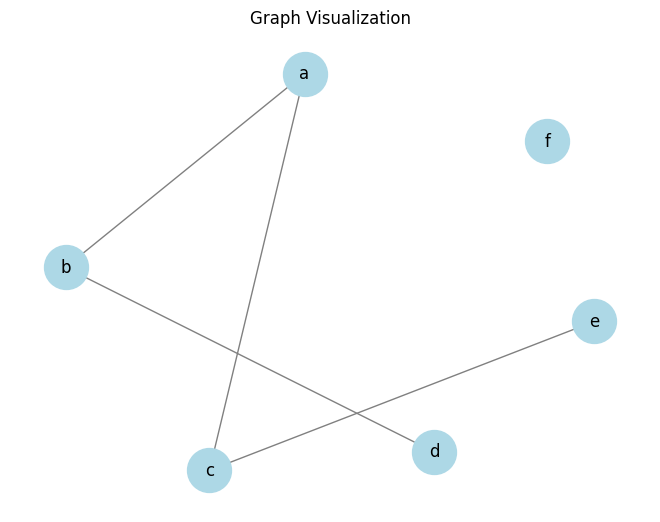

Słownik list sąsiedztwa grafu z nowym wierzchołkiem:
a: b c
b: a d
c: a e
d: b
e: c
f:
u:

Słownik list sąsiedztwa grafu z nową krawędzią:
a: b c u
b: a d
c: a e
d: b
e: c
f:
u: a



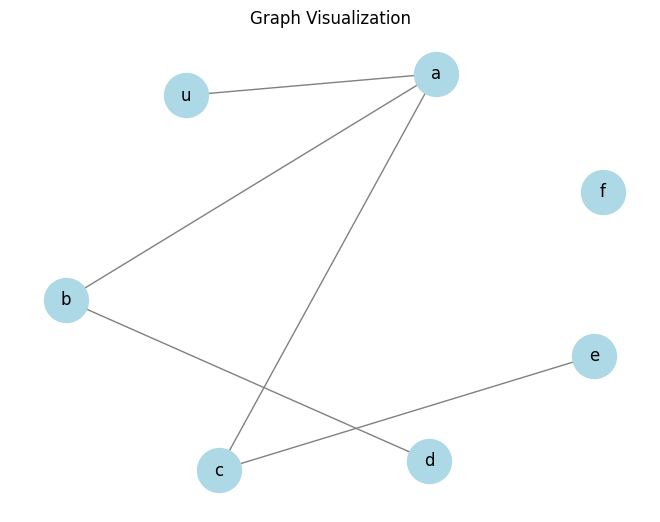

In [4]:
graph_dict = {"a": ["b", "c"],
              "b": ["a", "d"],
              "c": ["a", "e"],
              "d": ["b"],
              "e": ["c"],
              "f": []}
new_graph = Graph(graph_dict, is_directed=False)
print("Słownik list sąsiedztwa grafu:")
print(new_graph)
print("Macierz sąsiedztwa grafu:")
new_graph_matrix = new_graph._dict_to_matrix(new_graph.dict)
display(new_graph_matrix)
print("Wizualizacja grafu:")
new_graph.plot()

new_vertex = "u"
print("Słownik list sąsiedztwa grafu z nowym wierzchołkiem:")
new_graph.add_vertex(new_vertex)
print(new_graph)
print("Słownik list sąsiedztwa grafu z nową krawędzią:")
new_edge = ("a", "u")
new_graph.add_edge(new_edge)
print(new_graph)
new_graph.plot()

# Grafy losowe

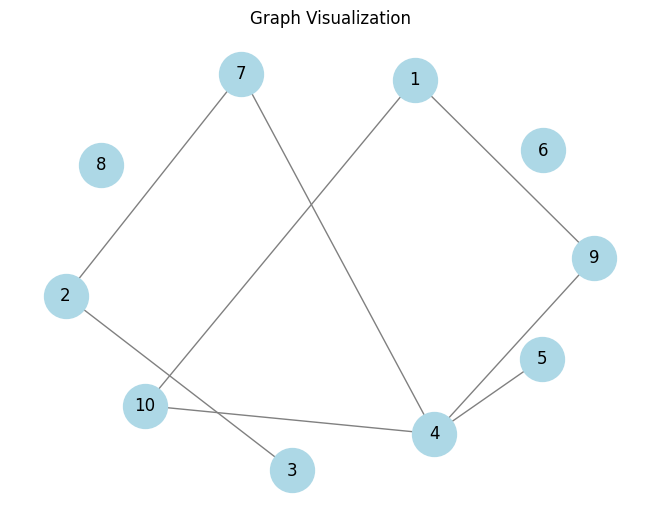

In [5]:
random_graph = Graph.generate_random_graph(vertices_count = 10, prob = 1/4, random_seed=1)
random_graph.plot()

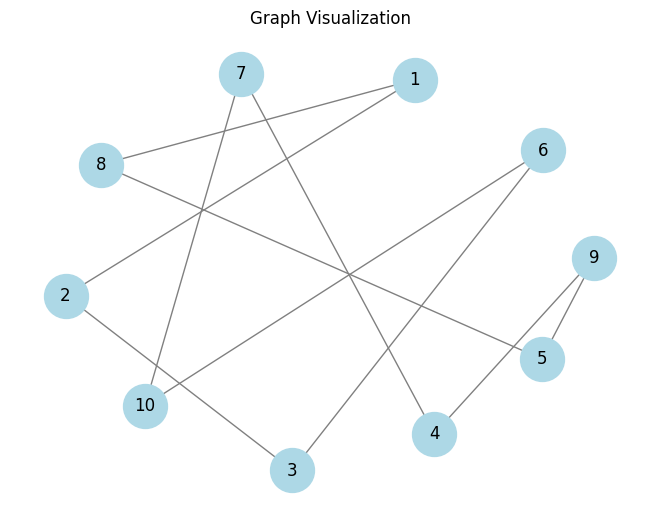

In [6]:
random_cycle = Graph.generate_random_cycle(vertices_count=10, random_seed=1)
random_cycle.plot()

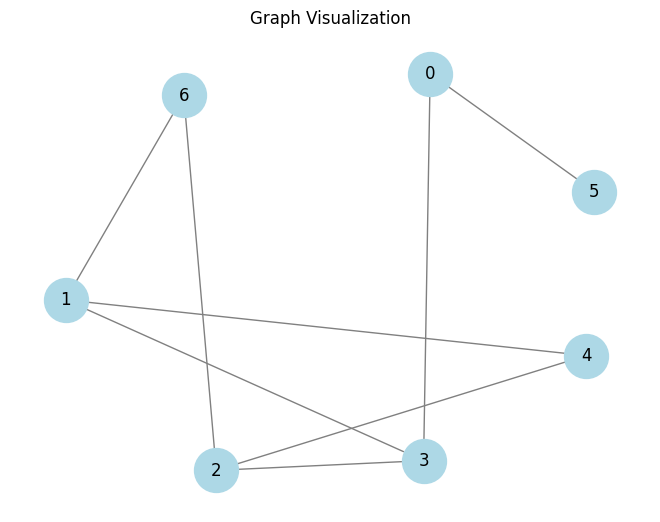

In [7]:
bipartite_graph = Graph.generate_random_bipartite_graph(3, 4, prob=2/3, random_seed=1)
bipartite_graph.plot()

# Zapis i odczyt grafów

In [8]:
%%writefile from_edges_list.txt
a b
a c
b d
c e
f

Overwriting from_edges_list.txt


%cat from_edges_list.txt

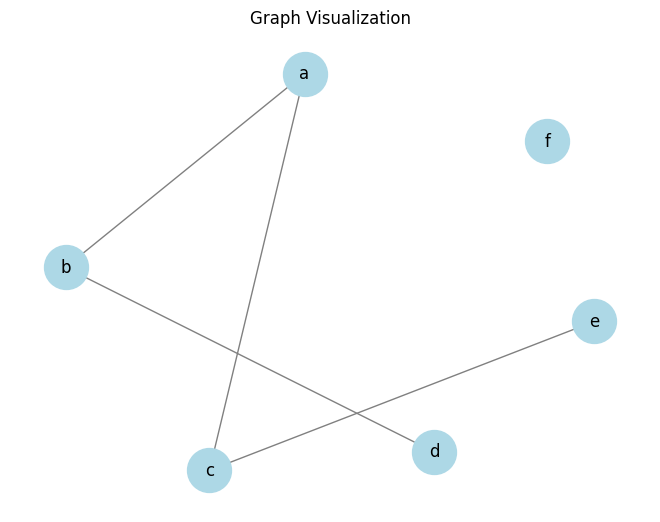

In [9]:
graph_from_edges_list = Graph.from_edges_list_file("from_edges_list.txt")
graph_from_edges_list.plot()

In [10]:
%%writefile from_neighbours_list.txt
a: b c
b: a b d
c: a b
d: c

Overwriting from_neighbours_list.txt


%cat from_neighbours_list.txt

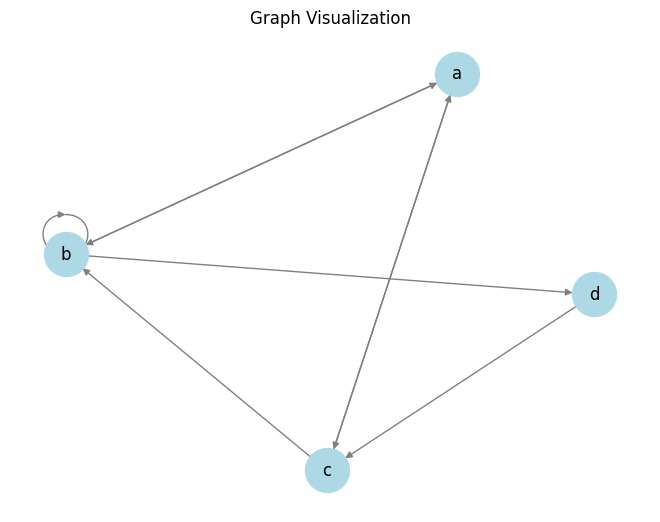

In [11]:
graph_from_neighbours_list = Graph.from_neighbours_list_file("from_neighbours_list.txt", is_directed=True)
graph_from_neighbours_list.plot()

In [12]:
graph_from_neighbours_list.to_edges_list_file("to_edges_list.txt")

%cat to_neighbours_list.txt

In [13]:
graph_from_edges_list.to_neighbours_list_file("to_neighbours_list.txt")

%cat to_neighbours_list.txt

## Porządki w drzewach i kody Prufera

In [14]:
graph_from_edges_list.Prufer_code()

'b a c e'

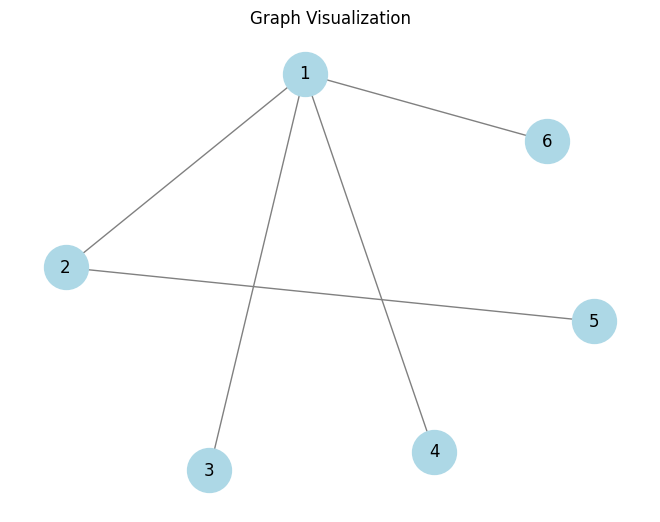

In [15]:
graph_from_prufer_code = Graph.tree_from_Prufer("1 1 2 1")
graph_from_prufer_code.plot()

In [16]:
print("Preorder:", graph_from_prufer_code.preorder(1))
print("Postorder:", graph_from_prufer_code.postorder(1))

Preorder: [1, 3, 4, 2, 5, 6]
Postorder: [3, 4, 5, 2, 6, 1]


## Spójne składowe oraz porządek topologiczny

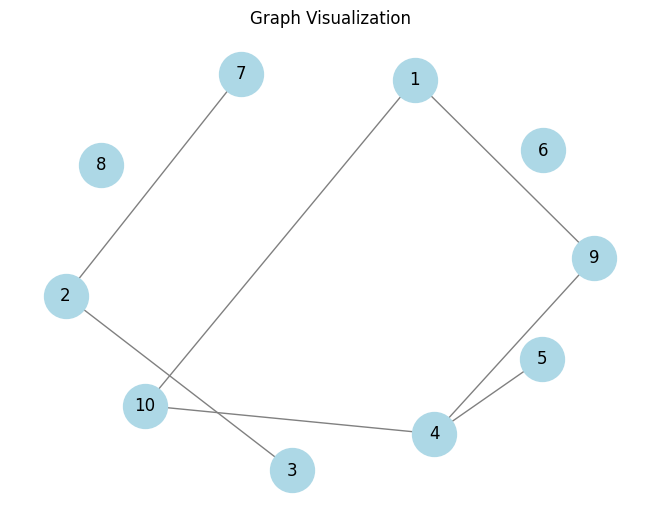

Spójne składowe DFS:


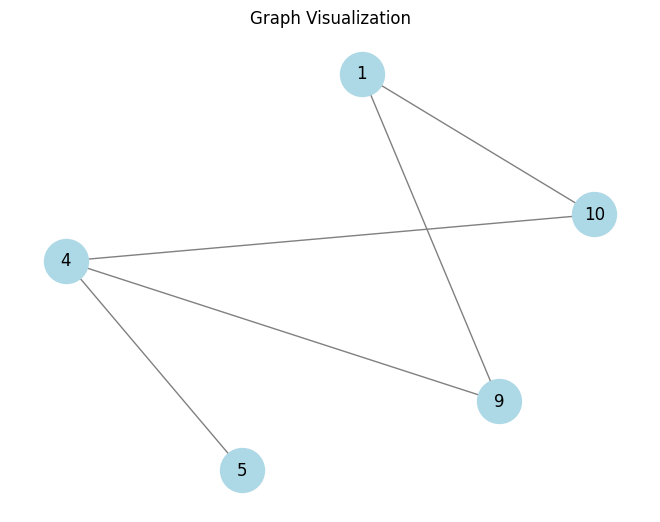

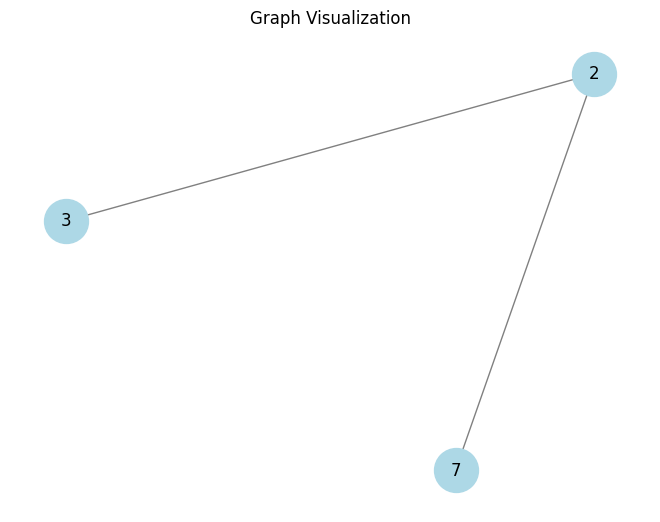

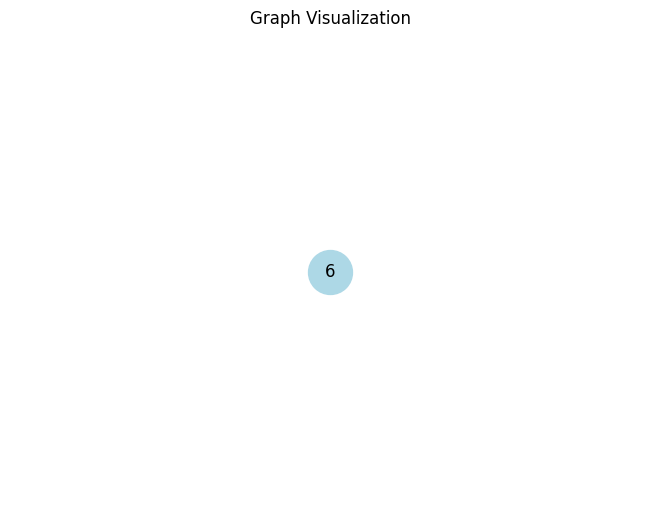

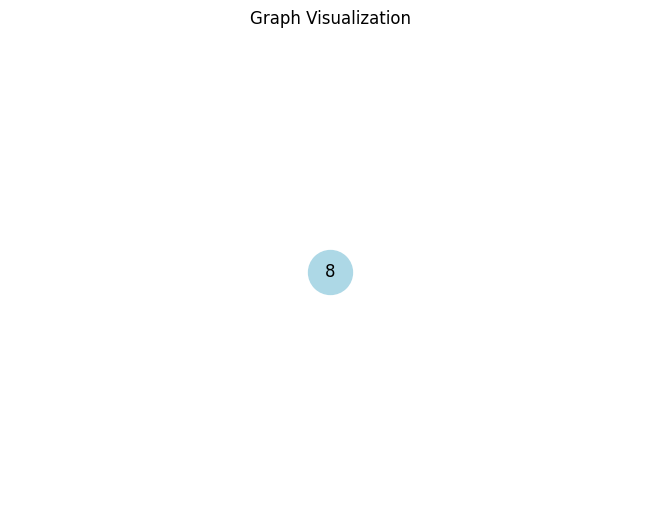

In [17]:
graph1 = Graph.generate_random_graph(10, 1/5, random_seed=1)
graph1.plot()
graph1.distances(1)
print("Spójne składowe DFS:")
connected_componentsDFS = graph1.connected_components()
for graph in connected_componentsDFS:
   graph.plot()

Spójne składowe BFS:


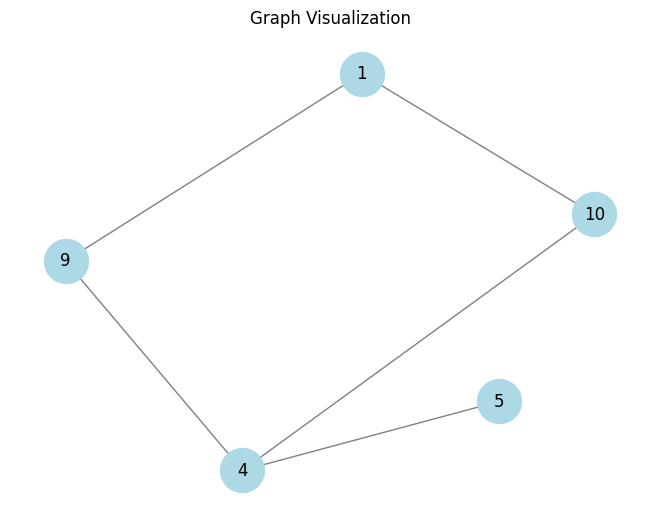

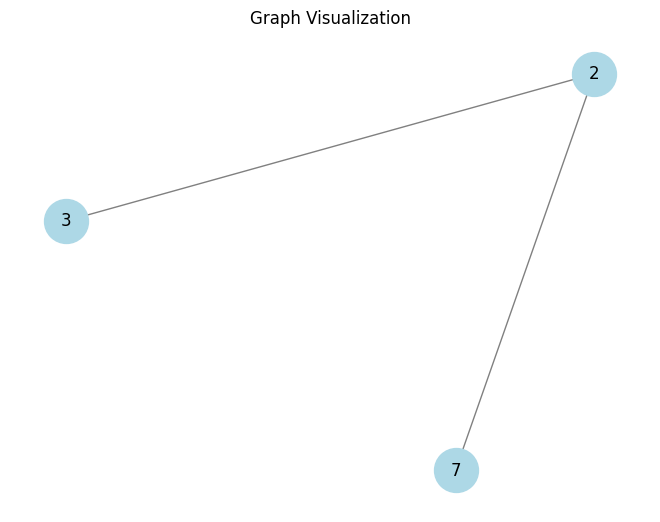

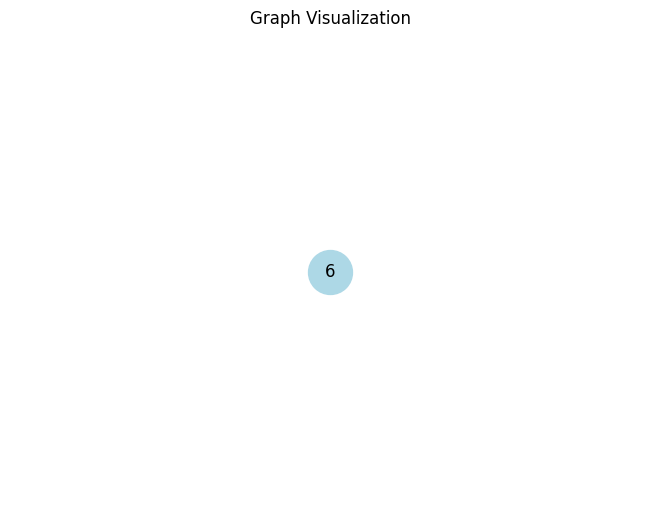

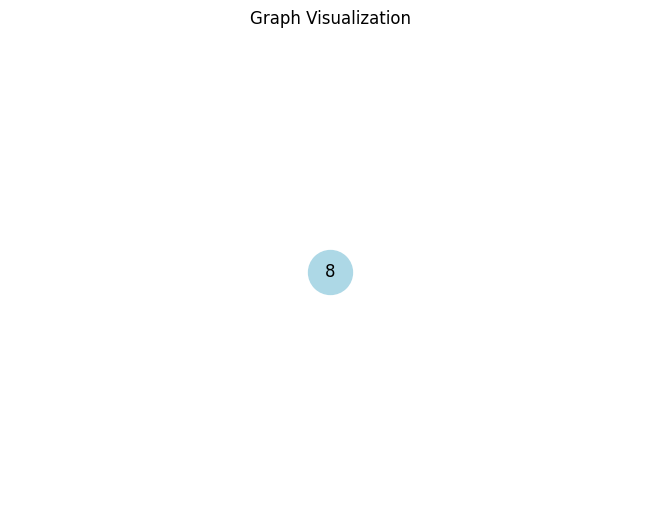

In [18]:
print("Spójne składowe BFS:")
connected_componentsBFS = graph1.connected_components(version="BFS")
for graph in connected_componentsBFS:
   graph.plot()

In [19]:
%%writefile acyclic_graph.txt
a: b c
b: 
c: b
d: c b
e: a c 

Overwriting acyclic_graph.txt


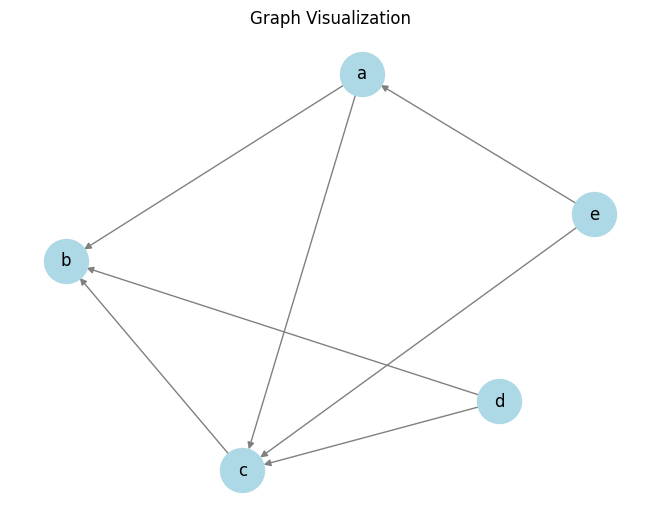

['d', 'e', 'a', 'c', 'b']

In [20]:
acyclic_graph = Graph.from_neighbours_list_file("acyclic_graph.txt", is_directed=True)
acyclic_graph.plot()
acyclic_graph.topological_sort()

Strongly connected components:


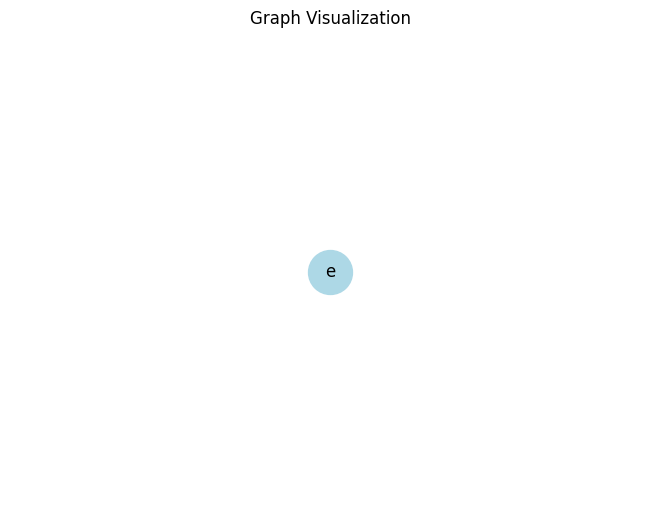

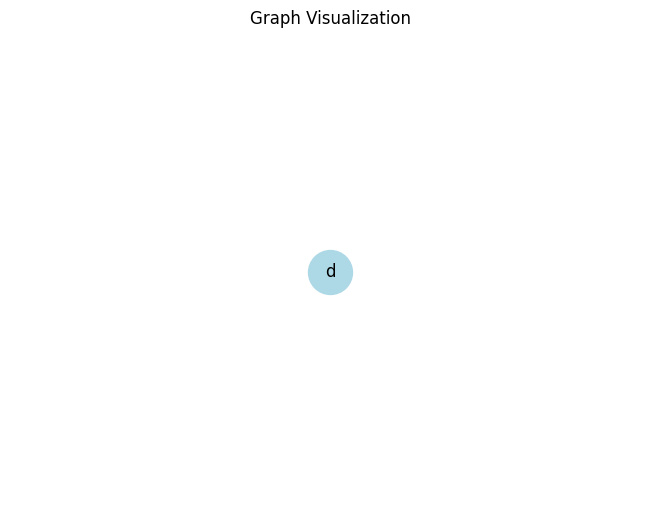

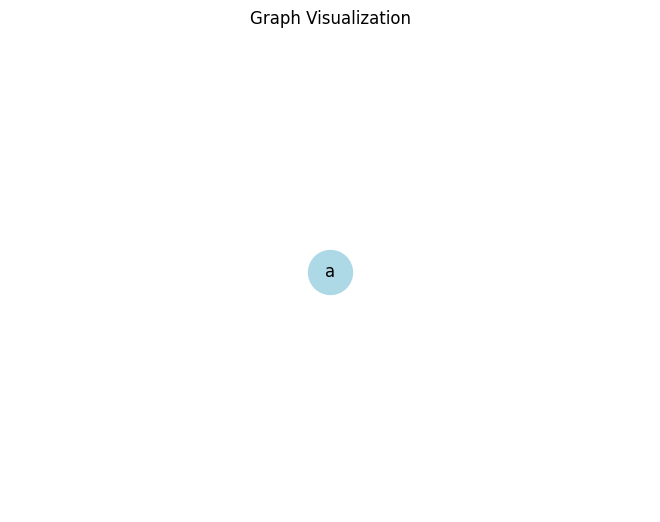

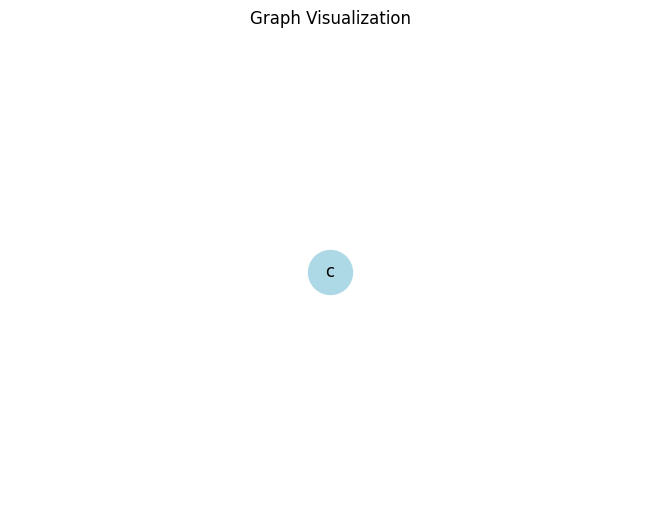

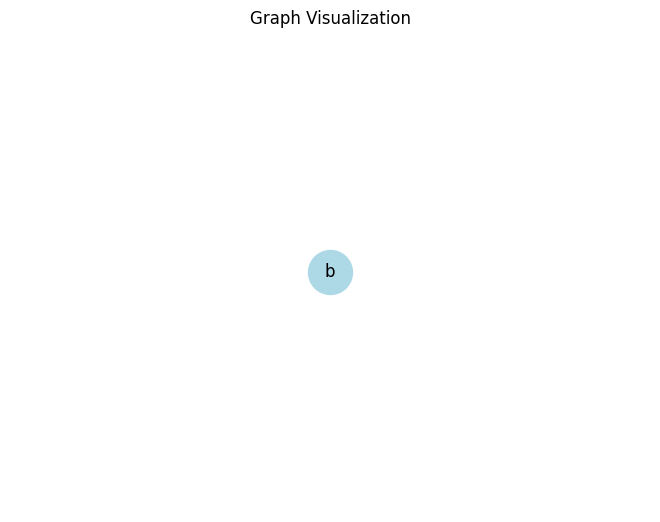

In [21]:
strongly_connected_components_acyclic = acyclic_graph.strongly_connected_components()
print("Strongly connected components:")
for graph in strongly_connected_components_acyclic:
    graph.plot()

In [22]:
%%writefile directed_graph.txt
a: b c e
b: d
c: b
d: b c
e: a c 
f: a d

Overwriting directed_graph.txt


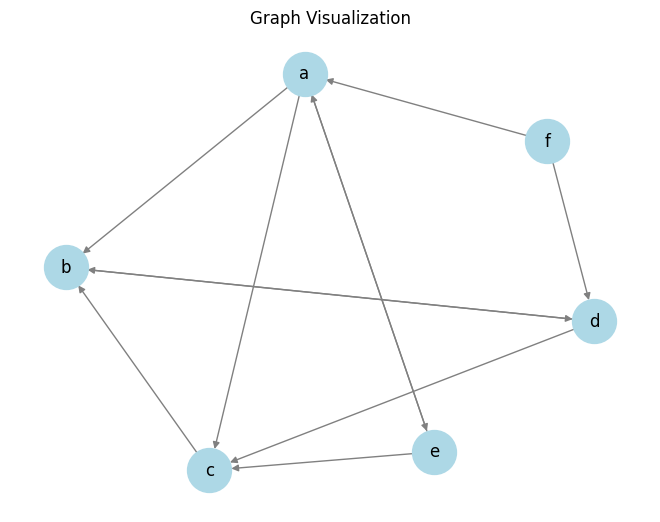

Strongly connected components:


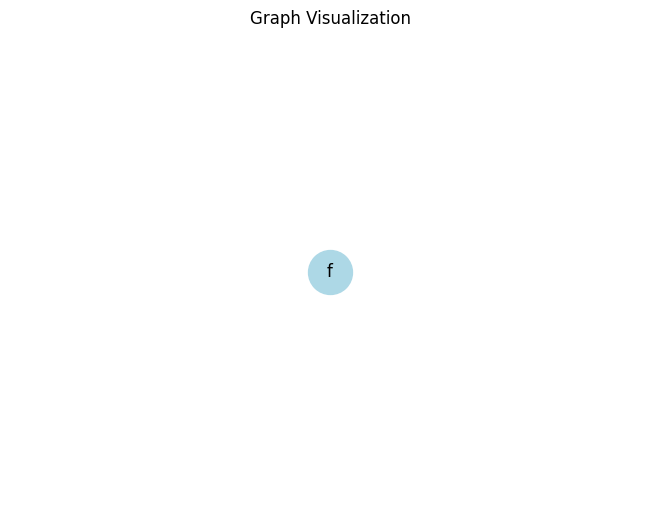

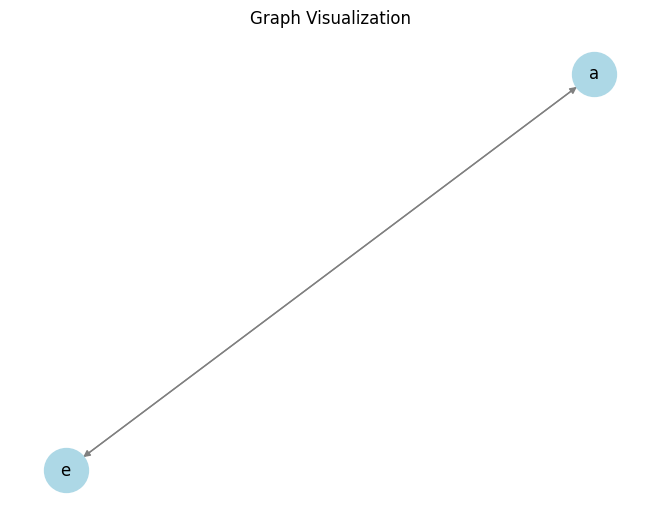

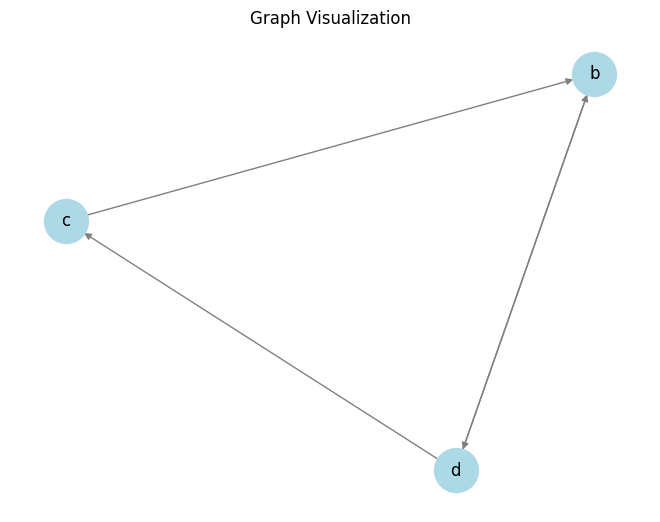

In [23]:
directed_graph = Graph.from_neighbours_list_file("directed_graph.txt", is_directed=True)
directed_graph.plot()

strongly_connected_components_directed = directed_graph.strongly_connected_components()
print("Strongly connected components:")
for graph in strongly_connected_components_directed:
   graph.plot()

## Eksperyment Milgrama (małego świata)

In [24]:
n = 2000
p =1/300
random_graph = Graph.generate_random_graph(n, p, random_seed=1)
graph = (random_graph.connected_components())[0]
print(len(graph.dict.keys()))

1997


In [25]:
md = {}
acc = {}
for v in graph.dict.keys():
   dist = graph.distances(v)
   acc[v] = max(dist.values())
   md[v] = (sum(dist.values()))/len(dist.values())
print(f"Radius: {min(acc.values())}, Diameter: {max(acc.values())}, Mean: {(sum(md.values()))/len(md.values())}")

Radius: 5, Diameter: 8, Mean: 4.189393755129439


## Grafy ważone

In [26]:
url = "https://raw.githubusercontent.com/pgordin/OptDisc2025/refs/heads/main/weighted0.txt"
if not os.path.exists("weighted0.txt"):
    wget.download(url)

In [27]:
#!wget https://raw.githubusercontent.com/pgordin/OptDisc2025/refs/heads/main/weighted0.txt

A: B(3) E(10)
B: A(3) C(26) D(12)
E: A(10) D(7) F(8) H(4)
C: B(26) D(17) F(13) G(14)
D: B(12) C(17) E(7) F(15)
F: C(13) D(15) E(8) G(9) H(6)
G: C(14) F(9) H(16) I(11)
H: E(4) F(6) G(16)
I: G(11)



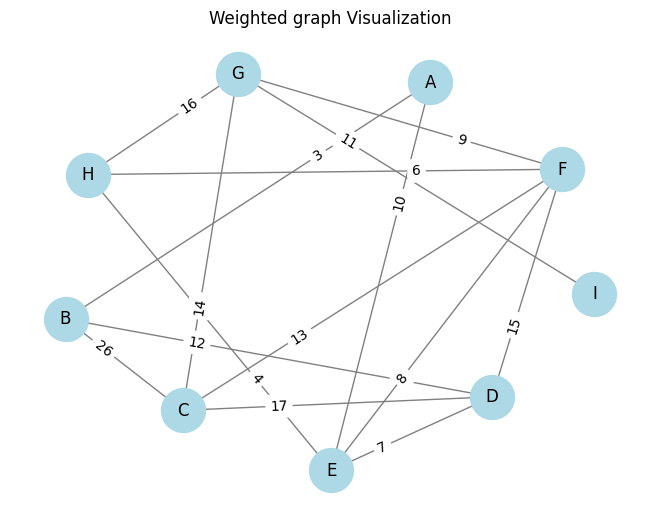

In [28]:
graph_from_lecture = WeightedGraph.from_edges_list_file("weighted0.txt")
print(graph_from_lecture)
graph_from_lecture.plot(weights_pos=0.3)

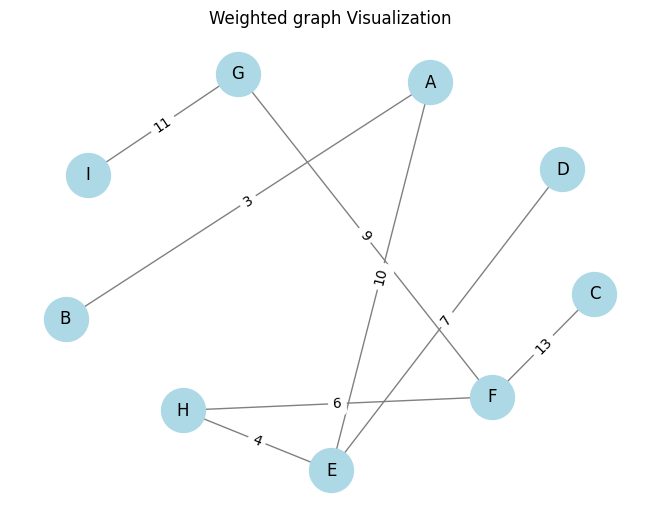

Total weight: 63


In [29]:
weighted_tree, total_weight = graph_from_lecture.min_spanning_tree()
weighted_tree.plot()
print("Total weight:", total_weight)

In [30]:
print("Odległości algorytmem Dijsktry:")
distances_Dijkstra, previous_Dijkstra = graph_from_lecture.Dijkstra("A")
print(distances_Dijkstra)
print(previous_Dijkstra)
print("Odległości algorytmem Bellmana-Forda:")
distances_Bellman_Ford, previous_Bellman_Ford = graph_from_lecture.Bellman_Ford("A")
print(distances_Bellman_Ford)
print(previous_Bellman_Ford)

Odległości algorytmem Dijsktry:
{'A': 0, 'B': 3, 'E': 10, 'C': 29, 'D': 15, 'F': 18, 'G': 27, 'H': 14, 'I': 38}
{'A': None, 'B': 'A', 'E': 'A', 'C': 'B', 'D': 'B', 'F': 'E', 'G': 'F', 'H': 'E', 'I': 'G'}
Odległości algorytmem Bellmana-Forda:
{'A': 0, 'B': 3, 'E': 10, 'C': 29, 'D': 15, 'F': 18, 'G': 27, 'H': 14, 'I': 38}
{'A': None, 'B': 'A', 'E': 'A', 'C': 'B', 'D': 'B', 'F': 'E', 'G': 'F', 'H': 'E', 'I': 'G'}


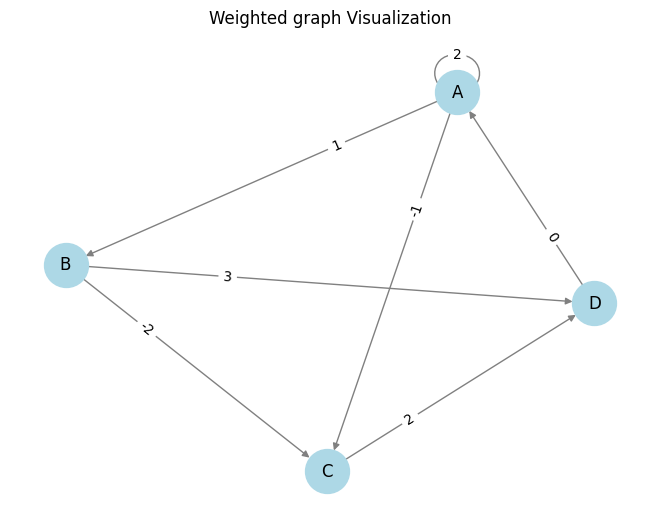

In [31]:
negative_weights_graph = WeightedGraph.from_edges_list_file("negative_weights_graph.txt", is_directed=True)
negative_weights_graph.plot(weights_pos=0.3)

In [32]:
print("Odległości algorytmem Dijsktry:")
distances_Dijkstra, previous_Dijkstra = negative_weights_graph.Dijkstra("A")
print(distances_Dijkstra)
print(previous_Dijkstra)
print("Odległości algorytmem Bellmana-Forda:")
distances_Bellman_Ford, previous_Bellman_Ford = negative_weights_graph.Bellman_Ford("A")
print(distances_Bellman_Ford)
print(previous_Bellman_Ford)

Odległości algorytmem Dijsktry:
{'A': 0, 'B': 1, 'C': -1, 'D': 1}
{'A': None, 'B': 'A', 'C': 'A', 'D': 'C'}
Odległości algorytmem Bellmana-Forda:
{'A': 0, 'B': 1, 'C': -1, 'D': 1}
{'A': None, 'B': 'A', 'C': 'A', 'D': 'C'}


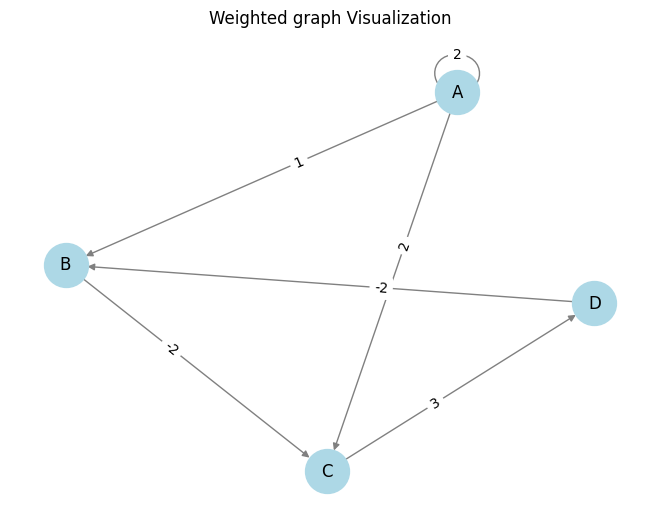

In [33]:
negative_cycle_graph = WeightedGraph.from_edges_list_file("negative_cycle_graph.txt", is_directed=True)
negative_cycle_graph.plot(weights_pos=0.4)

In [34]:
print("Odległości algorytmem Bellmana-Forda:")
distances_Bellman_Ford, previous_Bellman_Ford = negative_cycle_graph.Bellman_Ford("A")
print(distances_Bellman_Ford)
print(previous_Bellman_Ford)

Odległości algorytmem Bellmana-Forda:


ValueError: Graph has at least one cycle with a negative weight, so optimal distances can be negative infinity.

Algorytm Dijkstry wpada w nieskończoną pętlę, więc bez dodatkowych wyjątków lepiej go nie włączać dla tego grafu.

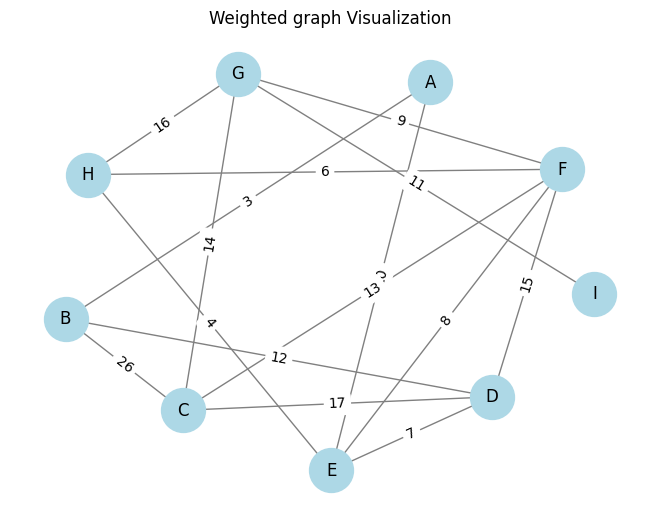

In [50]:
graph_from_lecture.plot()

In [51]:
cost_matrix = WeightedGraph.dict_to_matrix(graph_from_lecture.dict, graph_from_lecture.weights)
print(f"Kolejność kolumn: {list(graph_from_lecture.dict.keys())}")
np.array(graph_from_lecture.Floyd_Warshall(cost_matrix))

Kolejność kolumn: ['A', 'B', 'E', 'C', 'D', 'F', 'G', 'H', 'I']


array([[ 0,  3, 10, 29, 15, 18, 27, 14, 38],
       [ 3,  0, 13, 26, 12, 21, 30, 17, 41],
       [10, 13,  0, 21,  7,  8, 17,  4, 28],
       [29, 26, 21,  0, 17, 13, 14, 19, 25],
       [15, 12,  7, 17,  0, 15, 24, 11, 35],
       [18, 21,  8, 13, 15,  0,  9,  6, 20],
       [27, 30, 17, 14, 24,  9,  0, 15, 11],
       [14, 17,  4, 19, 11,  6, 15,  0, 26],
       [38, 41, 28, 25, 35, 20, 11, 26,  0]])

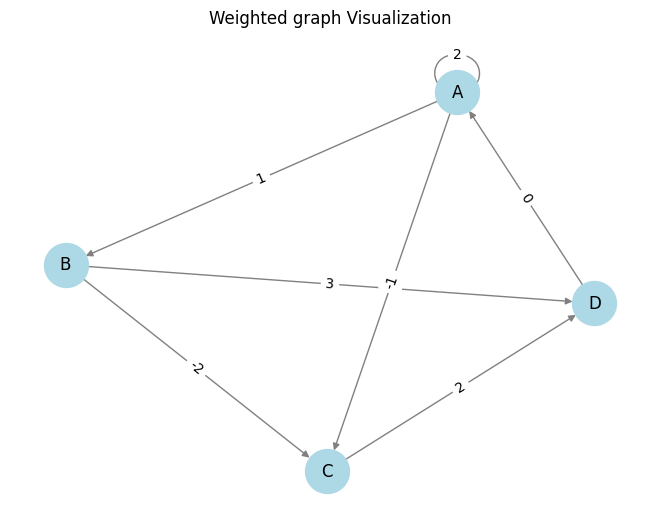

In [52]:
negative_weights_graph.plot()

In [53]:
cost_matrix = WeightedGraph.dict_to_matrix(negative_weights_graph.dict, negative_weights_graph.weights)
print(f"Kolejność kolumn: {list(negative_weights_graph.dict.keys())}")
np.array(negative_weights_graph.Floyd_Warshall(cost_matrix))

Kolejność kolumn: ['A', 'B', 'C', 'D']


array([[ 1,  1, -1,  1],
       [ 0,  0, -2,  0],
       [ 2,  3,  0,  2],
       [ 0,  1, -1,  0]])